In [1]:
import cv2
import sys
from matplotlib import pyplot as plt
from pylab import *
import numpy as np
from PIL import Image 
from skimage import data
from skimage import filters
from skimage import exposure
from skimage.color import rgb2gray
from scipy.signal import convolve2d
from skimage.filters import threshold_otsu
from skimage.filters import try_all_threshold


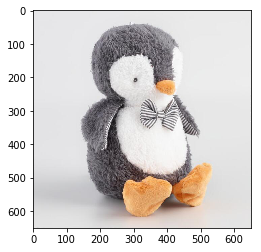

In [2]:
image = imread('penguin.jpg');
plt.imshow(image)

In [3]:
#cv2.getGaborKernel(ksize,sigma,theta,lambda,gamma,psi,ktype)
#ksize= size of gabor filter (n,n)
#sigma - standard deviation of the gaussian function
#theta - orientation of normal to parallel stripes
#lambda - wavelength of sinusoidal factor
#gamma - spatial aspect ratio
#psi - phase offset
#ktype - type and range of values that each pixel in the gabor kernel can hold

In [4]:
def myimshow (I, **kwargs):
    plt.figure();
    plt.axis('off')
    plt.imshow(I, cmap = plt.gray(),**kwargs)

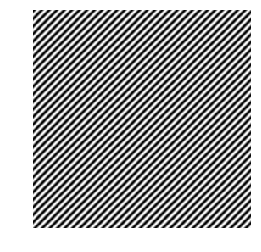

In [5]:
def genSinusoid(sz, A, omega, rho):
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x,y] = np.meshgrid(range(-radius[0], radius [0]+1), range(-radius[1], radius [1]+1))
    
    stimuli = A * np.cos(omega[0] * x + omega[1]*y + rho)
    return stimuli
theta = np.pi/4
omega = [np.cos(theta), np.sin(theta)]
sinusoidParam = {'A':1, 'omega':omega, 'rho':np.pi/2, 'sz':(256,256)}
myimshow(genSinusoid(**sinusoidParam))

1.5140274644582015e-05

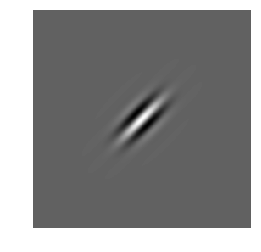

In [6]:
def genGabor(sz, omega, theta, func=np.cos, K=np.pi):
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)
    
    gauss = omega**2 / (4*np.pi * K**2) * np.exp(- omega**2 / (8*K**2) * ( 4 * x1**2 + y1**2))
#     myimshow(gauss)
    sinusoid = func(omega * x1) * np.exp(K**2 / 2)
#     myimshow(sinusoid)
    gabor = gauss * sinusoid
    return gabor
        
g = genGabor((256,256), 0.3, np.pi/4, func=np.cos) 
# change func to "cos", "sin" can generate sin gabor or cos gabor, here we pass a function name as a parameter
myimshow(g)
np.mean(g)

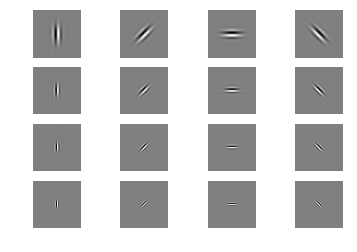

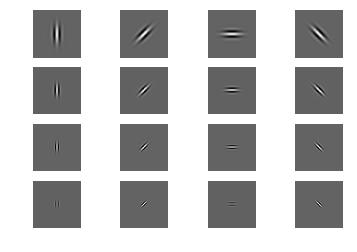

In [7]:
theta = np.arange(0,np.pi, np.pi/4)
omega = np.arange(0.2,0.6,0.1)
params = [(t,o) for o in omega for t in theta]
sinFilterBank = []
cosFilterBank = []
gaborParams = []
for (theta, omega) in params:
    gaborParam = {'omega':omega, 'theta':theta, 'sz':(256,256)}
    sinGabor = genGabor(func=np.sin, **gaborParam)
    cosGabor = genGabor(func=np.cos, **gaborParam)
    sinFilterBank.append(sinGabor)
    cosFilterBank.append(cosGabor)
    gaborParams.append(gaborParam)
    
plt.figure()
n = len(sinFilterBank)
for i in range(n):
    plt.subplot(4,4,i+1)
    plt.axis('off'); plt.imshow(sinFilterBank[i])
    
plt.figure()
for i in range(n):
    plt.subplot(4,4,i+1)
    plt.axis('off');plt.imshow(cosFilterBank[i])

Wall time: 37.2 s


<Figure size 432x288 with 0 Axes>

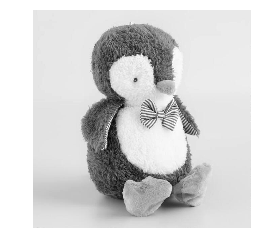

<Figure size 432x288 with 0 Axes>

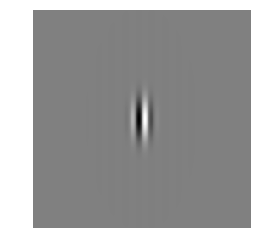

<Figure size 432x288 with 0 Axes>

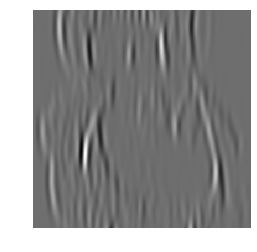

In [8]:
from skimage.color import rgb2gray
from scipy.signal import convolve2d
penguin = rgb2gray(plt.imread('penguin.jpg'))
plt.figure(); myimshow(penguin)
sinGabor = sinFilterBank[8] 
plt.figure(); myimshow(sinGabor)
%time res = convolve2d(penguin, sinGabor, mode='valid') 
plt.figure(); myimshow(res);

Wall time: 44.3 s


<Figure size 432x288 with 0 Axes>

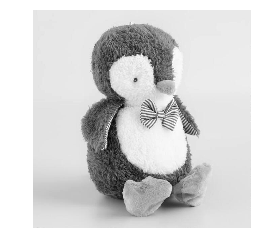

<Figure size 432x288 with 0 Axes>

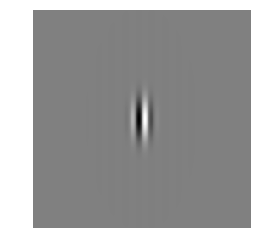

<Figure size 432x288 with 0 Axes>

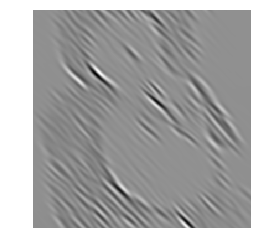

In [9]:
from skimage.color import rgb2gray
from scipy.signal import convolve2d
penguin = rgb2gray(plt.imread('penguin.jpg'))
plt.figure(); myimshow(penguin)
cosGabor = cosFilterBank[15] 
plt.figure(); myimshow(sinGabor)
%time res = convolve2d(penguin, cosGabor, mode='valid') 
plt.figure(); myimshow(res);


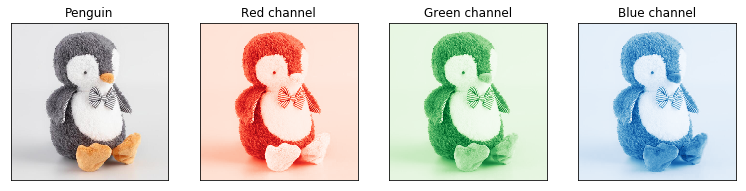

In [10]:
from matplotlib.cbook import get_sample_data

image = plt.imread('penguin.jpg')

titles = ['Penguin', 'Red channel', 'Green channel', 'Blue channel']
cmaps = [None, plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, axes = plt.subplots(1, 4, figsize=(13,3))
objs = zip(axes, (image, *image.transpose(2,0,1)), titles, cmaps)

for ax, channel, title, cmap in objs:
    ax.imshow(channel, cmap=cmap)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())

plt.savefig('RGB1.png')

In [15]:
image = plt.imread('penguin.jpg')
thetas = np.arange(0, np.pi,np.pi/16)
def build_filters():
    filters = []
    kern = cv2.getGaborKernel((51,51), 4.0, 1, 10.0, 0.5, 0, cv2.CV_32F)
    kern /= math.sqrt((kern*kern).sum())
    filters.append(kern)

In [16]:
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

In [17]:
def process_threaded(img, filters, threadn = 8):
    accum = np.zeros_like(img)
    def f(kern):
        return cv2.filter2D(img, cv2.CV_8UC3, kern)
    pool = ThreadPool(processes=threadn)
    for fimg in pool.imap_unordered(f, filters):
        np.maximum(accum, fimg, accum)
    return accum

In [23]:
if __name__ == '__main__':
    import sys
def Timer(msg):
    print(msg, '...',)
    start = clock()
    try:
        yield
    finally:
        print("%.2f ms" % ((clock()-start)*1000))

    print(__doc__)
    try:
        img_fn = sys.argv[1]
    except:
        img_fn = 'penguin.jpg'
        img = cv2.imread(img_fn)
        
#if img is None:
 #       print('Failed to load image file:', img_fn)
  #      sys.exit(1)


img = cv2.imread(img_fn)
filters = build_filters()
    
with Timer('running single-threaded'):
    res1 = process(img, filters)
with Timer('running multi-threaded'):
    res2 = process_threaded(img, filters)
        
print (res1 == res2.all()
       plt.imshow('penguin.jpg', img)
       plt.imshow('result', res2)

SyntaxError: invalid syntax (<ipython-input-23-cefdbe1946ac>, line 32)